In [1]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import psycopg2
import pandas as pd

from tabulate import tabulate

import time

import numpy as np

import os

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers


In [2]:
try:
    connection = psycopg2.connect(user = "postgres",
                                  password = "y4nkeedoodle",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "rcave")

    cursor = connection.cursor()
    # Print PostgreSQL Connection properties
    print ( connection.get_dsn_parameters(),"\n")

    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")

except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)

finally:
    z=0
    #cursor = connection.cursor()
    vehicleid=1
    cursor.execute("""
                    select 
                        status,
                        min(updated_at)::text as waktu, 
                        extract(epoch from min(updated_at)) as mulai, 
                        extract(epoch from max(updated_at)) as selesai 
                    from 
                        sensorpower 
                    where 
                        vehicle_id={vehicleid} 
                    group by 
                        status
                    order by 
                        min(updated_at) desc""".format(vehicleid=vehicleid))
    rows = cursor.fetchall()
    #print(rows)
    #print(tabulate(rows, headers=['status', 'waktu', 'mulai', 'selesai'], tablefmt='psql'))
    dataindex = 1
    #print("Trajectory Pilihan dengan index {index}".format(index=dataindex))
    #print(rows[dataindex])
    status = rows[dataindex][0] 
    mulai = rows[dataindex][2] 
    selesai = rows[dataindex][3]     
    maxdata = 10
    interval = 10 #detik

    z=z+1
    now = mulai+interval*z
    bottom = now - maxdata *interval
    if ((selesai-mulai)/maxdata > interval):
       interval = round((now-bottom)/maxdata)
    print('\n\nBerikut ini untuk display status power dengan\ndata max({maxdata}) dengan interval {interval}s '.format(maxdata=maxdata, interval=interval))
    cursor.execute("""
        select 
        p.k*{interval} as waktu,
        max(p.speed) as speed,
        max(p.bat_curr) as intake_pressure,
        max(p.eng_load) as eng_load,
        max(p.throttle) as throttle,
        avg(p.rpm) as rpm
    from 
        (
            select
                ((extract(epoch from updated_at)- {mulai})) as waktu,
                floor((extract(epoch from updated_at)- {mulai})/{interval}) as k,
                *
            from
                sensorpower
        ) as p
    left join
        vehicle as v on v.id=p.vehicle_id
    WHERE 1=1
        and p.vehicle_id={vehicleid}
        and p.status='{status}'
    group by 
        v.title, p.status, p.k
    order by 
        p.k""".format(mulai=mulai, interval=interval, vehicleid=vehicleid, status=status,bottom=bottom,now=now))

    rows = cursor.fetchall()

    df = pd.DataFrame( [[ij for ij in i] for i in rows] )

        #print(df)
            
    if(connection):
      cursor.close()
      connection.close()
      print("PostgreSQL connection is closed")

{'user': 'postgres', 'dbname': 'rcave', 'host': '127.0.0.1', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 9.5.20, compiled by Visual C++ build 1800, 64-bit',) 



Berikut ini untuk display status power dengan
data max(10) dengan interval 10s 
PostgreSQL connection is closed


In [26]:
data = df[[1,3,4,5,2]]
data = data.astype('float64')
data_x=data.values

for i in range(data_x.shape[1]):
    data_x[:,i]=data_x[:,i]/np.linalg.norm(data_x[:,i])

In [8]:
save = np.zeros((3,3,3))

model0 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,input_shape=(5,),activation = 'relu'),
    tf.keras.layers.Dense(16,activation = 'relu'),    
    tf.keras.layers.Dense(4,activation = 'relu'),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(5,activation = 'linear')
])
model0.summary()
a=0
b=0
c=0
model0.compile(optimizer=tf.keras.optimizers.Adam(lr =0.0003),loss='mse')
history = model0.fit(data_x, data_x,batch_size=16, epochs=100,validation_split=0.2)
save[a,b,c]=history.history["val_loss"][-1]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                192       
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_27 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_28 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 165       
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
____________________________________________________

606/606 [==============================] - 0s 100us/sample - loss: 7.4129e-06 - val_loss: 8.5445e-06
Epoch 63/100
606/606 [==============================] - 0s 112us/sample - loss: 7.5595e-06 - val_loss: 7.0343e-06
Epoch 64/100
606/606 [==============================] - 0s 123us/sample - loss: 7.2983e-06 - val_loss: 6.0725e-06
Epoch 65/100
606/606 [==============================] - 0s 125us/sample - loss: 7.3538e-06 - val_loss: 7.2086e-06
Epoch 66/100
606/606 [==============================] - 0s 105us/sample - loss: 7.6277e-06 - val_loss: 6.3556e-06
Epoch 67/100
606/606 [==============================] - 0s 112us/sample - loss: 7.2504e-06 - val_loss: 7.5500e-06
Epoch 68/100
606/606 [==============================] - 0s 127us/sample - loss: 7.5429e-06 - val_loss: 6.7598e-06
Epoch 69/100
606/606 [==============================] - 0s 117us/sample - loss: 7.2938e-06 - val_loss: 6.5035e-06
Epoch 70/100
606/606 [==============================] - 0s 99us/sample - loss: 7.3122e-06 - val_loss:

In [24]:
checkpoint_path = "training_anomaly/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [34]:
df

,0,1,2,3,4,5
0,0.0,59,96.0,100.00,62.75,1975.7500000000000000
1,10.0,64,97.0,94.51,29.41,1585.3333333333333333
2,20.0,66,97.0,100.00,56.47,1823.3333333333333333
3,30.0,66,94.0,100.00,27.45,1489.6666666666666667
4,40.0,61,96.0,100.00,39.22,1370.0000000000000000
...,...,...,...,...,...,...
753,7580.0,21,89.0,100.00,35.29,1950.3333333333333333
754,7590.0,12,71.0,87.06,16.08,1639.0000000000000000
755,7600.0,12,74.0,86.67,16.08,1072.3333333333333333
756,7610.0,3,34.0,43.53,7.06,744.6666666666666667


3.480304556821904e-05

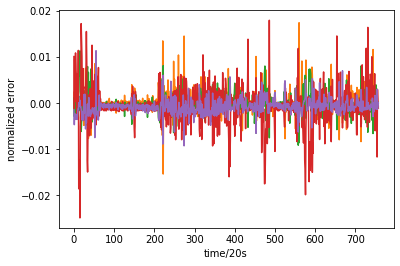

In [43]:
plt.plot(model0.predict(data_x)-data_x)
plt.ylabel('normalized error')
plt.xlabel('time/20s')
sum(np.square((model0.predict(data_x)-data_x)).flatten())/data_x.shape[0]

Text(0.5, 0, 'time/20s')

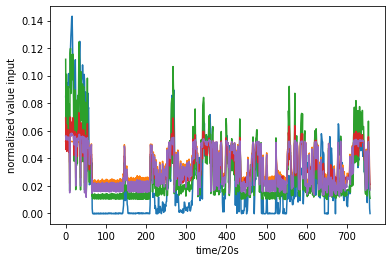

In [28]:
plt.plot(model0.predict(data_x))
plt.ylabel('normalized value input')
plt.xlabel('time/20s')

Text(0.5, 0, 'time/20s')

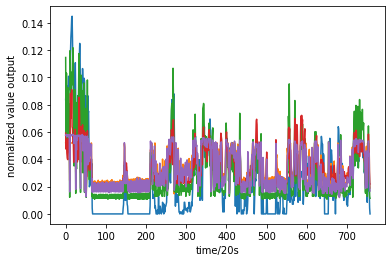

In [29]:
plt.plot(data_x)
plt.ylabel('normalized value output')
plt.xlabel('time/20s')

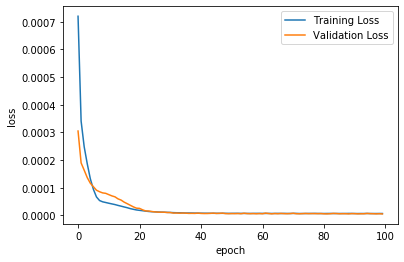

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

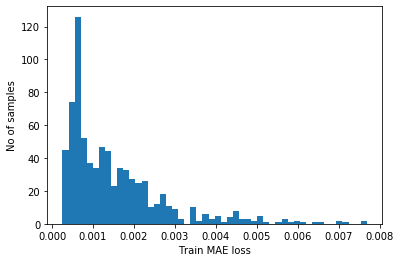

Reconstruction error threshold:  0.00768813815465158


In [15]:
x_train_pred = model0.predict(data_x)
train_mae_loss = np.mean(np.abs(x_train_pred - data_x), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [16]:
r_size = 758
rem = data_x.shape[0]-r_size
scale = 0.25
dataer=[]
units = 100
for i in range (units):
    curr_scale = scale *i/units
    x_test = data_x + np.append((np.random.rand(r_size,5)-0.5)*curr_scale,np.zeros((rem,5)),axis=0)
    x_test_pred = model0.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    anomalies = (test_mae_loss > threshold).tolist()        
    dataer.append([curr_scale,np.sum(anomalies)])

Text(0.5, 0, 'size of noise')

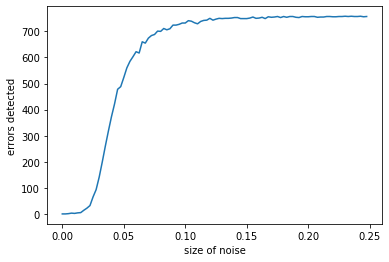

In [22]:
plt.plot(np.array(dataer)[:,0],np.array(dataer)[:,1])
plt.ylabel('errors detected')
plt.xlabel('size of noise')

In [18]:
#x_test = data_x + np.append((np.random.rand(r_size,5)-0.5)*0.1,np.zeros((rem,5)),axis=0)
cheat_sheet=np.zeros((758*5,1))
quest = np.zeros((758*5,5))
for i in range (data_x.shape[1]):
    data = df[[1,3,4,5,2]]
    data = data.astype('float64')
    data_x=data.values

    for j in range(data_x.shape[1]):
        data_x[:,j]=data_x[:,j]/np.linalg.norm(data_x[:,j])
        
    x_test = data_x
    x_test[:,i]=x_test[:,i]+np.append(np.sin(np.linspace(-np.pi, np.pi,r_size)).flatten()*0.1,np.zeros((rem,1)).flatten(),axis=0)

    x_test_pred = model0.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)   
    anomalies = (test_mae_loss > threshold).tolist()
    
    cheat_sheet[i*758:i*758+758]=(i+1)*np.array(anomalies).reshape(758,1)
    quest[i*758:i*758+758] = x_test
    
    print("Number of anomaly samples: ", np.sum(anomalies))


Number of anomaly samples:  264
Number of anomaly samples:  649
Number of anomaly samples:  577
Number of anomaly samples:  629
Number of anomaly samples:  641


Text(0.5, 0, 'time/20s')

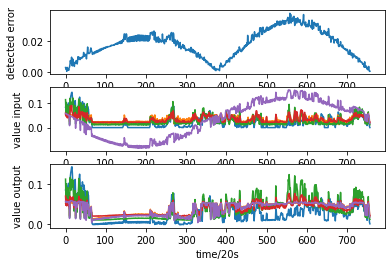

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(test_mae_loss)
ax1.set_ylabel('detected error')
ax2.plot(x_test)
ax2.set_ylabel('value input')
ax3.plot(x_test_pred)
ax3.set_ylabel('value output')
ax3.set_xlabel('time/20s')

In [20]:
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  641
Indices of anomaly samples:  (array([ 15,  18,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
  

In [ ]:
model_disc = tf.keras.Sequential()
model_disc.add(layers.Dense(128,input_shape=quest[0].shape,activation = 'relu'))
model_disc.add(layers.Dense(128,activation = 'relu'))
model_disc.add(layers.Dense(128,activation = 'relu'))
model_disc.add(layers.Dense(len(cheat_sheet[0]),activation = 'softmax'))
model_disc.summary()

model_disc.compile(optimizer=tf.keras.optimizers.Adam(lr =0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_disc.fit(quest, cheat_sheet,batch_size=16, epochs=300)

In [1]:
df

NameError: name 'df' is not defined

In [323]:
cheat_sheet.shape

(3790, 1)

In [283]:
    for j in range(data_x.shape[1]):
        data_x[:,i]=data_x[:,i]/np.linalg.norm(data_x[:,i])